In [1]:
def read_sent(path):
    ents = []
    curEnts = []
    for line in open(path):
        line = line.strip()
        if line == '':
            ents.append(curEnts)
            curEnts = []
        elif line[0] == '#' and len(line.split('\t')) == 1:
            continue
        else:
            curEnts.append(line.split('\t')[1])
    return(ents)

def read_labels(path):
    ents = []
    curEnts = []
    for line in open(path):
        line = line.strip()
        if line == '':
            ents.append(curEnts)
            curEnts = []
        elif line[0] == '#' and len(line.split('\t')) == 1:
            continue
        else:
            curEnts.append(line.split('\t')[2])
    return(ents)

def read_index(path):
    ents = []
    curEnts = []
    for line in open(path):
        line = line.strip()
        if line == '':
            ents.append(curEnts)
            curEnts = []
        elif line[0] == '#' and len(line.split('\t')) == 1:
            continue
        else:
            curEnts.append(line.split('\t')[0])
    return(ents)

In [2]:
def column_to_list(df, column_name):
    """
    Convert a column in a DataFrame to a list of lists.

    Parameters:
    - df: DataFrame
        The DataFrame containing the column to be converted.
    - column_name: str
        The name of the column to be converted to a list.

    Returns:
    - lists: list
        A list of lists where each inner list corresponds to a row in the specified column.
    """
    column_values = df[column_name].tolist()
    lists = [list(arr) for arr in column_values]
    return lists


In [3]:
import pandas as pd

In [4]:
id2label = {0: '0',
            1: 'B-PER', 
            2: 'I-PER',
            3: 'B-ORG',
            4: 'I-ORG',
            5: 'B-LOC',
            6: 'I-LOC'
           }

In [5]:
label2id = {label: id for id, label in id2label.items()}

In [86]:
#Training data
trainin_data = pd.read_parquet('data/train-polish.parquet')
training_labels_num = column_to_list(trainin_data, 'ner_tags')
training_labels = [[id2label[label_id] for label_id in sequence] for sequence in training_labels_num]
training_sent =  column_to_list(trainin_data, 'tokens')

#flatten to one list to be able to use myutils
train_flat_labels = sum(training_labels, [])
train_flat_sent = sum(training_sent, [])

In [80]:
#test data
test_data = pd.read_parquet('data/test-polish.parquet')
test_labels_num = column_to_list(test_data, 'ner_tags')
test_labels = [[id2label[label_id] for label_id in sequence] for sequence in test_labels_num]

test_sent =  column_to_list(test_data, 'tokens')
test_index = [[i for i, _ in enumerate(sublist)] for sublist in test_labels]

#flatten to one list to be able to use myutils
test_flat_labels = sum(test_labels, [])
test_flat_sent = sum(test_sent, [])
test_flat_index = sum(test_index, [])

In [81]:
#validation data
validation_data = pd.read_parquet('data/validation-english.parquet')
dev_labels_num = column_to_list(validation_data, 'ner_tags')
dev_labels = [[id2label[label_id] for label_id in sequence] for sequence in dev_labels_num]

dev_sent =  column_to_list(validation_data, 'tokens')

#flatten to one list to be able to use myutils
dev_flat_labels = sum(dev_labels, [])
dev_flat_sent = sum(dev_sent, [])

In [9]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [10]:
pip install sacremoses

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [11]:
from transformers import AutoTokenizer
from transformers import HerbertTokenizer
from transformers import HerbertTokenizerFast
from transformers import BertTokenizer, BertModel

model_checkpoint = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
import pandas as pd
label_all_tokens = True

In [13]:
def tokenize_and_align_labels(sentences, tags, tokenizer):
    tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=True, padding=True)

    aligned_labels = []
    for i, label in enumerate(pd.Series(tags)):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs.data

In [14]:
dev_labels_num = [[label2id.get(label, label2id) for label in sublist] for sublist in dev_labels]
training_labels_num = [[label2id.get(label, label2id) for label in sublist] for sublist in training_labels]
test_labels_num = [[label2id.get(label, label2id) for label in sublist] for sublist in test_labels]


In [15]:
tokenized_dev_data = tokenize_and_align_labels(dev_sent, dev_labels_num, tokenizer)

In [16]:
tokenized_training_data = tokenize_and_align_labels(training_sent, training_labels_num, tokenizer)

In [17]:
tokenized_test_data = tokenize_and_align_labels(test_sent, test_labels_num, tokenizer)

In [18]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [19]:
from datasets import Dataset

In [20]:
train_dataset = Dataset.from_dict({
    'id': range(len(tokenized_training_data['input_ids'])),
    'input_ids': tokenized_training_data['input_ids'],
    'attention_mask': tokenized_training_data['attention_mask'],
    'labels': tokenized_training_data['labels']
})

dev_dataset = Dataset.from_dict({
    'id': range(len(tokenized_dev_data['input_ids'])),
    'input_ids': tokenized_dev_data['input_ids'],
    'attention_mask': tokenized_dev_data['attention_mask'],
    'labels': tokenized_dev_data['labels']
})

test_dataset = Dataset.from_dict({
    'id': range(len(tokenized_test_data['input_ids'])),
    'input_ids': tokenized_test_data['input_ids'],
    'attention_mask': tokenized_test_data['attention_mask'],
    'labels': tokenized_test_data['labels']
})

tried = pd.DataFrame.from_dict(test_dataset)
part1 = tried[:500]
part2 = tried[-500:]
win = pd.DataFrame.to_dict(pd.concat([part1, part2]))
test_dataset = {}
for key in win.keys():
    test_dataset[key] = list(win[key].values())
    


In [21]:
test_dataset = Dataset.from_dict(test_dataset)

In [22]:
!pip install seqeval 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [23]:
from datasets import load_metric

metric = load_metric("seqeval")

/tmp/ipykernel_31287/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/resa/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [24]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label = id2label
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
label_names = list(label2id.keys())

In [26]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Convert labels to a list of lists if it's a set
    if isinstance(labels, set):
        labels = [labels]

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [27]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [28]:
from transformers import TrainingArguments
from transformers import DataCollatorForTokenClassification


args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
metric = load_metric("seqeval")

/home/resa/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [29]:

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)
trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
[rank0]:[W reducer.cpp:1386] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.204800,0.179690,0.890380,0.905172,0.897715,0.952265
2,0.122500,0.175220,0.909242,0.911306,0.910273,0.956755
3,0.079200,0.185518,0.909295,0.921327,0.915271,0.959554
4,0.050400,0.198256,0.915428,0.922148,0.918776,0.961307
5,0.029900,0.211060,0.917226,0.924490,0.920844,0.961974


/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


TrainOutput(global_step=6250, training_loss=0.10695422515869141, metrics={'train_runtime': 1801.8503, 'train_samples_per_second': 55.499, 'train_steps_per_second': 3.469, 'total_flos': 1.08198077923328e+16, 'train_loss': 0.10695422515869141, 'epoch': 5.0})

In [31]:
# model.save_pretrained('pl_herbert')

In [32]:
trainer.evaluate()

{'eval_loss': 0.21106044948101044,
 'eval_precision': 0.917225682798275,
 'eval_recall': 0.9244904858495122,
 'eval_f1': 0.9208437560130844,
 'eval_accuracy': 0.9619743103116318,
 'eval_runtime': 78.0328,
 'eval_samples_per_second': 128.151,
 'eval_steps_per_second': 8.009,
 'epoch': 5.0}

# Evaluation

In [33]:
# from transformers import Trainer
# loaded_model = AutoModelForTokenClassification.from_pretrained("pl_mbert")
# trainer = Trainer(model = loaded_model)

In [34]:
# import pickle

# with open('pl_gold.pkl', 'rb') as f:
#     # Load the pickled data
#     pl_gold = pickle.load(f)

In [35]:
pl_gold = pd.read_csv('annotations/all_annotation_pl.csv', sep = ';')

In [36]:
pl_gold_labels_num = [eval(ner) for ner in pl_gold[1]]
pl_gold_labels = [[id2label[label_id] for label_id in sequence] for sequence in pl_gold_labels_num]
pl_gold_sent =  [eval(label) for label in pl_gold[0]]

In [37]:
pl_gold_labels_num = [[label2id.get(label, label2id) for label in sublist] for sublist in pl_gold_labels]

In [38]:
tokenized_pl_gold_data = tokenize_and_align_labels(pl_gold_sent, pl_gold_labels_num, tokenizer)

In [39]:
silver_labels_list = [eval(string_list) for string_list in pl_gold[2]]
gold_labels_list = [eval(string_list) for string_list in pl_gold[1]]
gold_word_list = [eval(string_list) for string_list in pl_gold[0]]

# Check if all lists have the same length at each index
for i in range(min(len(silver_labels_list), len(gold_labels_list), len(gold_word_list))):
    silver_len = len(silver_labels_list[i])
    gold_len = len(gold_labels_list[i])
    word_len = len(gold_word_list[i])
    
    if silver_len != gold_len or silver_len != word_len:
        print(f"At index {i}: Silver labels length = {silver_len}, Gold labels length = {gold_len}, Gold words length = {word_len}")
        


In [40]:
pl_gold = Dataset.from_dict({
    'id': range(len(tokenized_pl_gold_data['input_ids'])),
    'input_ids': tokenized_pl_gold_data['input_ids'],
    'attention_mask': tokenized_pl_gold_data['attention_mask'],
    'labels': tokenized_pl_gold_data['labels']
})

In [41]:
# import pickle

# with open('mbert_gold.pickle', 'rb') as f:
#     eng_gold = pickle.load(f)

In [42]:
model.to("cuda:0")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [65]:
predictions, labels, metrics = trainer.predict(test_dataset) #test_data dla silver i pl_gold dla gold
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

/home/resa/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'LOC': {'precision': 0.9187817258883249,
  'recall': 0.8701923076923077,
  'f1': 0.893827160493827,
  'number': 208},
 'ORG': {'precision': 0.8617021276595744,
  'recall': 0.8901098901098901,
  'f1': 0.8756756756756756,
  'number': 182},
 'PER': {'precision': 0.9041095890410958,
  'recall': 0.8979591836734694,
  'f1': 0.901023890784983,
  'number': 147},
 '_': {'precision': 0.9067357512953368,
  'recall': 0.8974358974358975,
  'f1': 0.9020618556701031,
  'number': 195},
 'overall_precision': 0.8977900552486188,
 'overall_recall': 0.8879781420765027,
 'overall_f1': 0.8928571428571428,
 'overall_accuracy': 0.9588194921070693}

In [66]:
for i in range(len(true_predictions)):
    print("Example", i+1)
    print("Predicted:", true_predictions[i])
    print("Real:", true_labels[i])
    print()

Example 1
Predicted: ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', '0']
Real: ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', '0']

Example 2
Predicted: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

Example 3
Predicted: ['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0']
Real: ['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', 'B-LOC', 'B-LOC', 'B-LOC', '0']

Example 4
Predicted: ['B-PER', 'B-PER', 'I-PER', 'I-PER', 'I-PER', '0', '0', '0'

In [67]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Flatten true labels and predicted labels
true_labels_flat = [label for sublist in true_labels for label in sublist]
predicted_labels_flat = [label for sublist in true_predictions for label in sublist]

# Get unique labels
unique_labels = sorted(list(set(true_labels_flat + predicted_labels_flat)))

# Calculate confusion matrix
cf_matrix = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=unique_labels)




In [68]:
cf_matrix

array([[1735,    5,    7,    1,    5,    7,    3],
       [   7,  182,    9,    4,    3,    3,    0],
       [   6,    3,  167,    2,    0,    4,    0],
       [   4,    4,    3,  136,    0,    0,    0],
       [   0,    2,    0,    0,   96,   10,    4],
       [   2,    0,    0,    0,    4,  230,    0],
       [  13,    0,    1,    1,    0,    3,  248]])

<Figure size 1000x800 with 0 Axes>

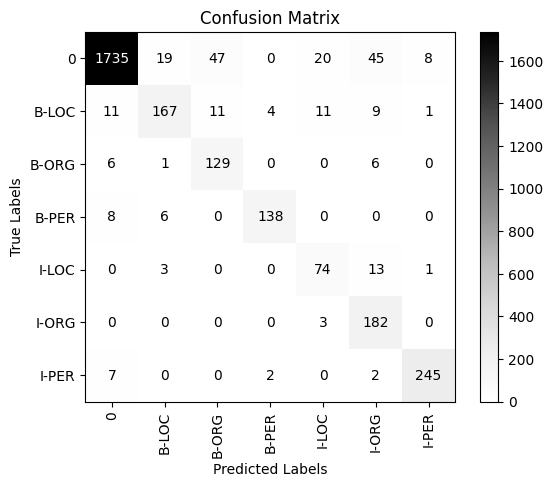

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp = disp.plot(cmap=plt.cm.Greys, values_format='d', xticks_rotation='vertical')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_gold_mbert")
plt.show()


In [51]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00 0:00:01


<Axes: >

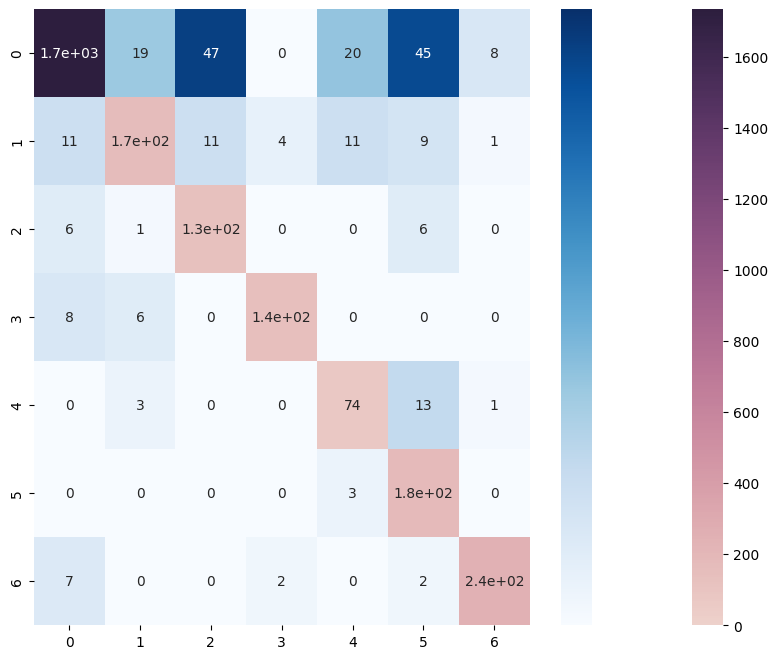

In [59]:
import seaborn as sns

vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)

fig = plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap=sns.cubehelix_palette(as_cmap=True), vmin=vmin, vmax=vmax)
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='Blues', vmin=vmin, vmax=50, cbar_kws=dict(ticks=[]))

In [72]:
train_flat_labels

['B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-ORG',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 'B-LOC',
 'I-LOC',
 'I-LOC',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-LOC',
 '0',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 '0',
 '0',
 'B-LOC',
 'I-LOC',
 'B-PER',
 'I-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-LOC',
 '0',
 'B-LOC',
 '0',
 'B-PER',
 'I-PER',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-ORG',
 'I-ORG',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'B-LOC'

In [87]:
org_count = 0
per_count = 0
loc_count = 0
none_count = 0

# Iterate through the list and count occurrences
for label in train_flat_labels:
    if label.startswith('B-ORG') or label.startswith('I-ORG'):
        org_count += 1
    elif label.startswith('B-PER') or label.startswith('I-PER'):
        per_count += 1
    elif label.startswith('B-LOC') or label.startswith('I-LOC'):
        loc_count += 1
    elif label == '0':
        none_count += 1

# Print the counts
print("ORG count:", org_count)
print("PER count:", per_count)
print("LOC count:", loc_count)
print("NONE count:", none_count)

ORG count: 22905
PER count: 20817
LOC count: 17067
NONE count: 105685


In [88]:
sumed = org_count+per_count+loc_count + none_count

In [89]:
org_per = org_count/sumed*100
per_per = per_count/sumed*100
loc_per = loc_count/sumed*100
none_per = none_count/sumed*100

In [90]:
print("ORG count:", org_per)
print("PER count:", per_per)
print("LOC count:", loc_per)
print("NONE count:", none_per)

ORG count: 13.758905294520465
PER count: 12.504655381621156
LOC count: 10.252051371385322
NONE count: 63.48438795247306


100.0